Our package has dependencies not available on the pypi index. So, a user should run the following command before installing/using our package:

in a venv, first pip install jupyter notebook

then:

pip install astropy astroquery matplotlib requests pandas scipy numpy scikit-learn pytest differint

Then, our package can be installed using:

pip install -i https://test.pypi.org/simple/ team09CS107Harvard2023==1.0.0

# Package Usage
## Core Functionality: Initialize

First, we will demonstrate usage of our base query class.

In [1]:
from group9_package.subpkg_1.core_functions_module_extract import SpectralAnalysisBase


query = "select top 10 ra, dec, bestObjID from specObj where class = 'galaxy'  and z > 0.3 and zWarning = 0"
astro = SpectralAnalysisBase(query)
astro.execute_query()
print(astro.data)


Query executed successfully and result stored in data attribute.
    ra       dec          bestObjID     
--------- ---------- -------------------
184.86409  52.571314 1237657629529211079
222.98982  42.629408 1237658203986460871
146.39863  5.8334459 1237658423547920434
49.459411   0.847754 1237660241924063461
172.28104  10.234226 1237658493349789816
156.25024  7.6586271 1237658425162858683
231.07321  32.718373 1237662341082382595
197.37712  10.524518 1237662238545478566
184.90501 -3.3095095 1237650760782053596
242.52563  6.0693494 1237662198290186255


Our base query class takes in any user query but any faulty queries are clearly recognizable through the raise of a value error. This cell should be an error.

In [2]:
from group9_package.subpkg_1.core_functions_module_extract import SpectralAnalysisBase

query = 'invalid query test'
astro1 = SpectralAnalysisBase(query)
astro1.execute_query()

Query Error: Query is invalid.


ValueError: Query is invalid.

## Core Functionality: Data Preprocessing

After obtaining our query, we move to **processing** it. We do this given how variable the flux of each spectrum may be. We expect to be able to handle the following transformations: (normalization, outlier removal, interpolation, redshift correction). Below demonstrates the usage of our DataPreprocessor module with its integration of our base class. We expect that the user provides a Z Score threshold to identify outliers. It defaults to 2.5 as we believed this to be standard value to do so. For the interpolate function, we expect the wavelengths the user wants to estimate to be provided. Lastly, our redshift correction expects to correct Ultraviolet (u), Green (g), Near Infrared (i), Infrared (z).

Pandas must be imported to convert our Table returned by initial query to a df. This is because we want to avoid mutating the queried object directly.
### Investigate changing this pre prod push^

Numpy is imported and used by the user to create a wavelength range to interpolate.


In [3]:
from group9_package.subpkg_1.core_functions_module_modify import DataPreprocessor
import pandas as pd
import numpy as np

query = "select top 10 ra, dec from specObj where class = 'galaxy'  and z > 0.3 and zWarning = 0"
astro = SpectralAnalysisBase(query)
astro.execute_query()

astro_df = astro.data.to_pandas()


data_preprocessor = DataPreprocessor(query=query,data=astro_df)
new_wavelengths = np.linspace(1, 4, len(astro_df))

data_preprocessor.normalize_data()
data_preprocessor.remove_outliers(2.5)
data_preprocessor.interpolate_data(new_wavelengths)
data_preprocessor.correct_redshift()

# display our processed data
display(data_preprocessor.data)

Query executed successfully and result stored in data attribute.


,ra,dec
0,0.115411,1.290704
1,0.842504,-73.129708
2,-0.618161,-917.390533
3,-2.466882,-3343.463413
4,-0.124559,-8163.319988
5,-0.430282,-16188.931899
6,0.996662,-28232.270787
7,0.354046,-45105.308293
8,0.116191,-67620.016056
9,1.215070,-96588.365719


## Core Functionality: Metadata Extraction

Next we move to our core functionalities. We begin with **metadata extraction**. For this functionality, we extract the (identifiers, coordinates, chemical abundances, redshifts, or other fields requested by end-user).


In [4]:
from group9_package.subpkg_1.core_functions_module_extract import SpectralAnalysisBase, MetaDataExtractor, SpectraExtract

query = "select top 10 ra, dec, elodieZ, bestObjID, elodieFeH from specObj where class = 'galaxy'  and z > 0.3 and zWarning = 0"
astro = MetaDataExtractor(query)
astro.execute_query()

Query executed successfully and result stored in data attribute.


 We save the instances of the different extract requests in the respective variables. We expect that if the user wants to extract any attribute, they do so in the following manner. This enforces better modularity as as to not modify the original data.

In [5]:
from group9_package.subpkg_1.core_functions_module_extract import SpectralAnalysisBase, MetaDataExtractor, SpectraExtract
identifiers = astro.extract_identifiers()
coordinates = astro.extract_coordinates()
chemicalAbundances = astro.extract_chemical_abundances()
redshifts = astro.extract_redshifts()
print(identifiers)
print(coordinates)
print(chemicalAbundances)
print(redshifts)

     bestObjID     
-------------------
1237650795146510903
1237648720142401774
1237648721216274720
1237650795683512955
                  0
1237650795683447026
1237648721216209489
1237651799621763660
1237648720142139722
1237650795146314138
     bestObjID          ra        dec    
------------------- --------- -----------
1237650795146510903 146.76339 -0.81043316
1237648720142401774 146.62282 -0.95138526
1237648721216274720 146.92403 -0.10514302
1237650795683512955 147.08969 -0.26650926
                  0 146.27838  -0.6115498
1237650795683447026 146.84292 -0.39093546
1237648721216209489 146.89733 -0.18636779
1237651799621763660 146.07916  -1.1580268
1237648720142139722 146.01189 -0.97522919
1237650795146314138 146.24259 -0.76261796
     bestObjID      elodieFeH
------------------- ---------
1237650795146510903         0
1237648720142401774         0
1237648721216274720         0
1237650795683512955         0
                  0         0
1237650795683447026         0
1237648721216209

We've also included an additional class for extracting spectra data. The below fetches spectrum from SDSS specifically using the plate, MJD, and fiber numbers. This means we'd expect the user to query for these specific attributes of spectroscopic data. These identifiers can be found with our query.

 First we create a SpectralAnalysisBase Class instance to execute the query. We expect a row of data to be queried for as an argument within SpectraExtract call. This same behavior can be used to get a full spectra data.


In [6]:
from group9_package.subpkg_1.core_functions_module_extract import SpectralAnalysisBase, MetaDataExtractor, SpectraExtract

query_galaxies = "select top 1 class, plate, mjd, fiberid, bestObjID from specObj where class = 'galaxy'"
galaxies = SpectralAnalysisBase(query_galaxies)
galaxies.execute_query()

spectra_extractor = SpectraExtract(galaxies.data[0])

# get spectra
spectra = spectra_extractor.extract_spectra()
print(spectra)

# Get full spectra
spectra_full = spectra_extractor.extract_spectra_full()
print(spectra_full)

Query executed successfully and result stored in data attribute.


/Users/hnunez/Desktop/example_notebook/venv5/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Successful Query!
      Wavelength   Flux  BestFit  SkyFlux
0       3605.786 -1.937   -0.015    3.395
1       3606.617 -3.299   -0.017    3.393
2       3607.447 -0.107   -0.019    3.440
3       3608.279  0.570   -0.022    3.407
4       3609.109 -2.820   -0.023    3.370
...          ...    ...      ...      ...
4580   10351.418  1.731    1.372   39.532
4581   10353.805  2.527    1.370   14.752
4582   10356.193  0.568    1.370   14.072
4583   10358.570  2.200    1.371   12.751
4584   10360.958  3.832    1.373    4.538

[4585 rows x 4 columns]
Request failed with status code: 500. Retrying...
Request failed with status code: 500. Retrying...
Successful Query!
          flux  loglam      ivar  and_mask    or_mask     wdisp        sky  \
0    -1.937115  3.5570  0.082223         0          0  1.142011   3.395389   
1    -3.299369  3.5571  0.079175         0          0  1.141888   3.393457   
2    -0.106838  3.5572  0.074978         0          0  1.141764   3.439501   
3     0.569755  3.5573 

## Core Functionality: Wavelength Alignment

Next, we've included our module for alignment in wavelength for all the spectra across a predefined range as mentioned in the contract.

The interpolation function similar to our preprocessing module takes in pre-defined wavelength range and interpolates across these.

The alignment function creates an instance of the Wavelength Alignment class and performs the alignment

In [7]:
from group9_package.subpkg_1.core_functions_module_modify import WavelengthAlignment

display(spectra_full)

# align to self - should not change
min_loglam = spectra_full['loglam'].min()
max_loglam = spectra_full['loglam'].max()

# Use the min and max as the range for the alignment - nothing should change
full_spectra_aligned = WavelengthAlignment.WavelengthAlign(spectra_full, (min_loglam, max_loglam))
display(full_spectra_aligned)


,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,-1.937115,3.5570,0.082223,0,0,1.142011,3.395389,-0.014616
1,-3.299369,3.5571,0.079175,0,0,1.141888,3.393457,-0.016814
2,-0.106838,3.5572,0.074978,0,0,1.141764,3.439501,-0.019323
3,0.569755,3.5573,0.080653,0,0,1.141640,3.407291,-0.021644
4,-2.820402,3.5574,0.082536,0,0,1.141517,3.370394,-0.023318
...,...,...,...,...,...,...,...,...
4580,1.731266,4.0150,0.077008,0,8388608,0.837787,39.532246,1.371676
4581,2.527200,4.0151,0.115658,0,0,0.838547,14.752366,1.370484
4582,0.568423,4.0152,0.152431,0,0,0.839308,14.071901,1.370290
4583,2.200193,4.0153,0.000000,0,0,0.840037,12.751198,1.371306


,loglam,flux,ivar,and_mask,or_mask,wdisp,sky,model
0,3.5570,-1.937115,0.082223,0,0,1.142011,3.395389,-0.014616
1,3.5571,-3.297522,0.079175,0,0,1.141888,3.393457,-0.016814
2,3.5572,-0.107898,0.074978,0,0,1.141764,3.439501,-0.019323
3,3.5573,0.568613,0.080653,0,0,1.141640,3.407291,-0.021644
4,3.5574,-2.818149,0.082536,0,0,1.141517,3.370394,-0.023318
...,...,...,...,...,...,...,...,...
4580,4.0150,1.731794,0.077008,0,8388608,0.837787,39.532246,1.371676
4581,4.0151,2.526648,0.115658,0,0,0.838547,14.752366,1.370484
4582,4.0152,0.572437,0.152431,0,0,0.839308,14.071901,1.370290
4583,4.0153,2.202406,0.000000,0,0,0.840037,12.751198,1.371306


## Core Functionality: Visualization

Lastly, for this package's core functionalities, we turn to our module for visualization. In this module, we've made it so the user is able to visualize spectral data either from a data frame or by extracting spectral data given a row of astronomical data from a query. The below simulates a given pandas dataframe that includes values for Wavelength and Flux. We understand that the respective values for each attribute may be more variable than in the example.

Below are examples of inputting data or inputting the row, with their respective usage. Here, we imported pandas and the respective package from ours, but pandas is only used to simulate some data.

The first result is a simulated dataframe

/Users/hnunez/Desktop/example_notebook/venv5/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Query executed successfully and result stored in data attribute.


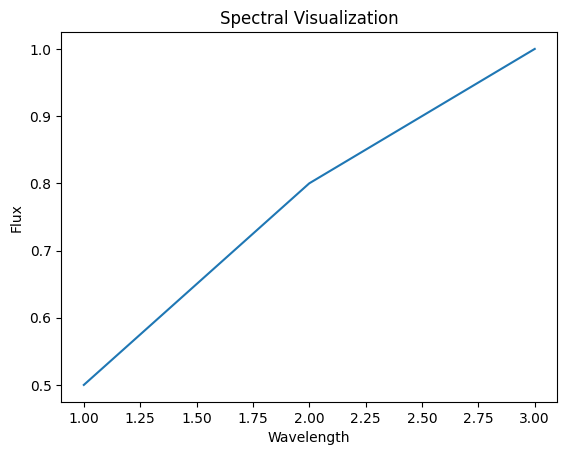

Successful Query!


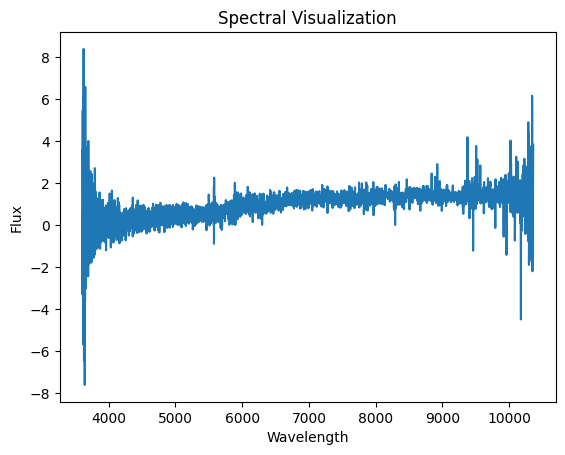

In [8]:
from group9_package.subpkg_1.visualize_module import SpectralVisualizer
import pandas as pd

query_galaxies = "select top 1 class, plate, mjd, fiberid, bestObjID from specObj where class = 'galaxy'"

# Create a SpectralAnalysisBase Class instance to execute the queries
galaxies = SpectralAnalysisBase(query_galaxies)
galaxies.execute_query()  # Execute the query
spectra_extractor = SpectraExtract(galaxies.data[0]) # Extract the spectral data

# Create fake data to visualize using spectral data
data = pd.DataFrame({'Wavelength': [1, 2, 3], 'Flux': [0.5, 0.8, 1.0]})
visualizer = SpectralVisualizer(row=None, data=data)
visualizer.visualize()


visualizer2 = SpectralVisualizer(row=galaxies.data[0], data=None)
visualizer2.visualize()

## Core Functionality: Data Augmentation Functionality

This cell shows the usage of our data augmentation.

Computes derivatives/fractional derivatives and appends them to each preprocessed spectra.

Functions:
__init__: Initializes spectral data attribute.

compute_derivative: Computes the derivative for each spectrum in the input data and appends a column to the data with the values. Takes a column name argument

compute_fractional_derivative: Computes the fractional derivative for each spectrum based on the specified order and appends the column to the data. Takes a column name argument and derivative order number

augment_data: Calls both of the above functions and appends two columns to the data. Takes a column name argument and derivative order number


In [9]:
from group9_package.subpkg_1.data_augmentation_module import DataAugmentation

dataAugmentor = DataAugmentation(data=spectra_full)
augmentedData = dataAugmentor.augment_both_derivatives(column_name='flux', derivative_order=0.5)
print(augmentedData)

dataAugmentor2 = DataAugmentation(data=spectra_full)
dataAugmentor2.compute_derivative(column_name='loglam')
dataAugmentor2.compute_fractional_derivative(column_name='loglam', derivative_order=0.2)
print(dataAugmentor2.data)

          flux  loglam      ivar  and_mask    or_mask     wdisp        sky  \
0    -1.937115  3.5570  0.082223         0          0  1.142011   3.395389   
1    -3.299369  3.5571  0.079175         0          0  1.141888   3.393457   
2    -0.106838  3.5572  0.074978         0          0  1.141764   3.439501   
3     0.569755  3.5573  0.080653         0          0  1.141640   3.407291   
4    -2.820402  3.5574  0.082536         0          0  1.141517   3.370394   
...        ...     ...       ...       ...        ...       ...        ...   
4580  1.731266  4.0150  0.077008         0    8388608  0.837787  39.532246   
4581  2.527200  4.0151  0.115658         0          0  0.838547  14.752366   
4582  0.568423  4.0152  0.152431         0          0  0.839308  14.071901   
4583  2.200193  4.0153  0.000000         0          0  0.840037  12.751198   
4584  3.831949  4.0154  0.143868         0  134217728  0.840804   4.538127   

         model  flux Derivative  flux_fractional_derivative  
0

## Machine Learning Functionality

Below is example usage of our machine learning module. We print out a confusion matrix and probability matrix.

In [11]:
from group9_package.subpkg_2.machine_learning_module import CelestialObjectClassifier
from group9_package.subpkg_1.core_functions_module_extract import SpectralAnalysisBase, SpectraExtract
import pandas as pd
from sklearn.model_selection import train_test_split

query_galaxies = "select top 1 class, plate, mjd, fiberid, bestObjID from specObj where class = 'galaxy'"
query_stars = "select top 1 class, plate, mjd, fiberid, bestObjID from specObj where class = 'star'"
query_qsos = "select top 1 class, plate, mjd, fiberid, bestObjID from specObj where class = 'qso'"

# Create a SpectralAnalysisBase Class instances to execute the queries
galaxies = SpectralAnalysisBase(query_galaxies)
galaxies.execute_query()  # Execute the query


stars = SpectralAnalysisBase(query_stars)
stars.execute_query()  # Execute the query

qsos = SpectralAnalysisBase(query_qsos)
qsos.execute_query() # Execute the query

# Create empty lists to store spectral data and classifications
spectral_data = []
classifications = []

# Function to extract spectral data and classifications
def process_data(query_data, classification):
    for row in query_data:
        spectra_extractor = SpectraExtract(row)
        spectra_data = spectra_extractor.extract_spectra()
        spectral_data.append(spectra_data)
        for _ in range(len(spectra_data)):
            classifications.append([classification])

# Process galaxies data
process_data(galaxies.data, "galaxy")

# Process stars data
process_data(stars.data, "star")

# Process qsos data
process_data(qsos.data, "qso")

# Create a DataFrame for spectral data
spectral_df = pd.concat(spectral_data, ignore_index=True)

# Create a DataFrame 'y' for classifications
y = pd.DataFrame(classifications, columns=["Classification"])

# Horizontally stack spectral_df and classifications
stacked_df = pd.concat([spectral_df, y], axis=1)

train_data, test_data = train_test_split(stacked_df, test_size=0.2, random_state=42)

X_train, y_train = train_data.drop(columns=["Classification"]), train_data["Classification"] 

X_test, y_test = test_data.drop(columns=["Classification"]), test_data["Classification"]

# Initialize the CelestialObjectClassifier
classifier = CelestialObjectClassifier()

# Fit the classifier with training data
classifier.fit(X_train, y_train)

# Make predictions and print confusion matrix
predictions = classifier.predict(X_test, y_test)

# Calculate prediction probabilities
prediction_probabilities = classifier.predict_proba(X_test)

# Print some results
print(f"Predictions: {predictions}")
print(f"Prediction Probabilities:\n{prediction_probabilities}")


/Users/hnunez/Desktop/example_notebook/venv5/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Query executed successfully and result stored in data attribute.
Query executed successfully and result stored in data attribute.
Query executed successfully and result stored in data attribute.
Successful Query!
Request failed with status code: 500. Retrying...
Successful Query!
Successful Query!
Confusion Matrix:
[[919   0  11]
 [ 10 740 163]
 [  6   2 918]]
Predictions: ['qso' 'qso' 'galaxy' ... 'star' 'qso' 'galaxy']
Prediction Probabilities:
[[2.56989335e-05 9.88990603e-01 1.09836981e-02]
 [1.74496687e-12 9.00476446e-01 9.95235545e-02]
 [9.95925045e-01 4.05726602e-03 1.76889478e-05]
 ...
 [1.70721439e-96 8.58764808e-04 9.99141235e-01]
 [6.50171545e-09 9.58304258e-01 4.16957355e-02]
 [9.92527767e-01 7.19814094e-03 2.74092285e-04]]


/Users/hnunez/Desktop/example_notebook/venv5/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Cross Matching Functionality

As our final functionality, we have a simple cross match as guided by victor zhu. the user inputs a gaia source id, and a cross match is returned if the threshold is met. The result is a dataframe containing the sdss match id and the distance of the neighbor.

In [12]:
from group9_package.subpkg_2.cross_matching_module import CrossMatchingModule
gaia_source_id = '6279435494640163584'
threshold = 1
crossmatch = CrossMatchingModule()
result = crossmatch.cross_match(threshold, gaia_source_id)
display(result)

,original_ext_source_id,angular_distance
0,1237671992426824447,0.053355
